In [1]:
from typing import List
import re

import numpy as np
from matplotlib import pyplot as plt
import matplotlib

# include the path to the parent directory

import sys
sys.path.append('../')

from mfgpflow.data_loader import StellarMassFunctions

# set a random number seed to reproducibility
np.random.seed(0)

# Calibrate CAMELS Hydro-sim-code-calibration Emulator

Here we try to find the mapping from one simulation code to another, on the summary statistics level.

Let's try the matter power spectrum level first. And then move to Bispectrum.

- AR1: Linear multi-fidelity emulator from [Kennedy M., O’Hagan A., 2000, ](https://academic.oup.com/biomet/article-pdf/87/1/1/590577/870001.pdf)
- NARGP: Non-linear multi-fidelity emulator from Perdikaris P., Raissi M., Damianou A., Lawrence N. D., Karniadakis G. E., 2017, Proc. R. Soc. A., 473

- 50LR-3HR emulator: an emulator trained on 50 LR simulations and 3 HR simulations.

Data from Public Release of CAMELS.


In [2]:
def generate_data(folder: str = "../data/illustris/illustris-5-8/1004_LR_7_HR_test0/"):
    data = StellarMassFunctions(folder=folder)
    return data

base_folder = "../data/illustris/illustris-5-8-log1p/full_1004_LR_8_HR_test0/"
data = generate_data(base_folder)

In [3]:
log10_mass_bins = np.array(
            [8.15, 8.45, 8.75, 9.05, 9.35, 9.65, 9.95, 10.25, 10.55, 10.85]
        )

Text(0, 0.5, '$SMF$')

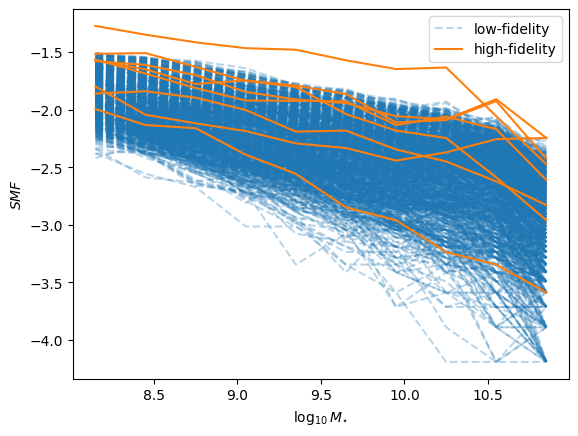

In [4]:
# visualize training spectra
for i, y_train in enumerate(data.Y_train_log10[0]):
    if i == 0:
        plt.plot(log10_mass_bins, y_train, label="low-fidelity", color="C0", ls="--", alpha=0.3)
    else:
        plt.plot(log10_mass_bins, y_train, color="C0", ls="--", alpha=0.3)
for i, y_train in enumerate(data.Y_train_log10[1]):
    if i == 0:
        plt.plot(log10_mass_bins, y_train, label="high-fidelity", color="C1")
    else:
        plt.plot(log10_mass_bins, y_train, color="C1")
plt.legend()
plt.xlabel(r"$\log_{10}M_{\star}$")
plt.ylabel(r"$SMF$")

In [5]:
np.any([True, False, True])

True

## Latent space inference : Factor analysis using the mixing matrix

In [6]:
from mfgpflow.linear_svgp import LatentMFCoregionalizationSVGP

In [17]:
import numpy as np
import gpflow
import tensorflow as tf
from sklearn.cluster import KMeans

# 🔹 1️⃣ Load Data
X_LF, Y_LF = data.X_train_norm[0], data.Y_train_norm_log10[0]  # LF Data (50, 5) → (50, 49)
X_HF, Y_HF = data.X_train_norm[1], data.Y_train_norm_log10[1]  # HF Data (3, 5) → (3, 49)
# X_test_HF, Y_test_HF = data.X_test_norm[0], data.Y_test[0]  # Test HF Data (10, 5) → (10, 49)

# 
X_test_HF, Y_test_HF = data.X_train_norm[1], data.Y_train_norm_log10[1]  # Test HF Data (10, 5) → (10, 49)

# 🔹 2️⃣ Prepare Training Data
n_LF, n_HF = X_LF.shape[0], X_HF.shape[0]  # Number of points
output_dim = Y_LF.shape[1]  # 49 output dimensions
num_latents = 5  # Reduce latent GPs to match HF sparsity
num_inducing = 100  # Reduce inducing points to prevent overfitting

# ✅ Append fidelity indicators (0 for LF, 1 for HF)
X_LF_aug = np.hstack([X_LF, np.zeros((n_LF, 1))])  # LF data with fidelity=0
X_HF_aug = np.hstack([X_HF, np.ones((n_HF, 1))])   # HF data with fidelity=1

# ✅ Combine datasets
X_train = np.vstack([X_LF_aug, X_HF_aug])  # Shape: (53, 6)
Y_train = np.vstack([Y_LF, Y_HF])  # Shape: (53, 49)

# 🔹 3️⃣ Define Multi-Fidelity GP Model
# ✅ Define base kernels for LF and HF discrepancy
kernel_L = gpflow.kernels.SquaredExponential(lengthscales=np.ones(6), variance=1.0)
kernel_delta = gpflow.kernels.SquaredExponential(lengthscales=np.ones(6), variance=1.0)

# ✅ Optimize Inducing Points using K-Means Clustering
kmeans = KMeans(n_clusters=num_inducing, random_state=42).fit(X_train)
Z_init = kmeans.cluster_centers_

# ✅ Initialize the Latent Multi-Fidelity Coregionalization SVGP model
mf_gp = LatentMFCoregionalizationSVGP(
    X_train, Y_train,
    kernel_L, kernel_delta,
    num_outputs=output_dim, num_latents=num_latents, Z=Z_init
)

import time
start = time.time()
# 🔹 4️⃣ Train the Model with Adaptive Learning Rate
mf_gp.optimize(
    (X_train, Y_train),
    max_iters=2000,  # Reduce training iterations
    initial_lr=0.1,  # Lower learning rate for stability
    unfix_noise_after=500,  # Delay unfixing noise variance
    # decay_lr=True  # Enable learning rate decay
)

print(f"Training Time: {time.time() - start:.2f} seconds")

🔹 KMeans Inducing Points: [[ 1.16416667e-01  3.16750000e-01  5.60452444e-01  1.39411556e-01
   4.28670556e-01  1.60931111e-01  0.00000000e+00]
 [ 7.28500000e-01  5.58083333e-01  1.19358444e-01  1.72427556e-01
   3.15178333e-01  4.10621111e-01  0.00000000e+00]
 [ 6.87078947e-01  5.93657895e-01  1.64007579e-01  6.71196491e-01
   1.41056491e-01  1.61857193e-01  1.73472348e-18]
 [ 2.92642857e-01  1.24857143e-01  1.24657524e-01  6.47205905e-01
   1.45383333e-01  8.34371429e-02  1.73472348e-18]
 [ 5.87833333e-01  8.44055556e-01  1.58517333e-01  6.69604444e-01
   5.63669630e-01  8.34169630e-01  0.00000000e+00]
 [ 5.11785714e-01  1.75309524e-01  1.09698159e-01  1.98083937e-01
   4.46281905e-01  2.03518095e-01  0.00000000e+00]
 [ 8.76500000e-01  8.58863636e-01  2.98453333e-01  1.10221091e-01
   3.00906667e-01  4.32090303e-01  0.00000000e+00]
 [ 1.29166667e-01  8.35166667e-01  8.04278519e-02  3.62620148e-01
   4.17445926e-01  1.99203704e-01  0.00000000e+00]
 [ 4.21625000e-01  3.52500000e-01  3.7

Loss history

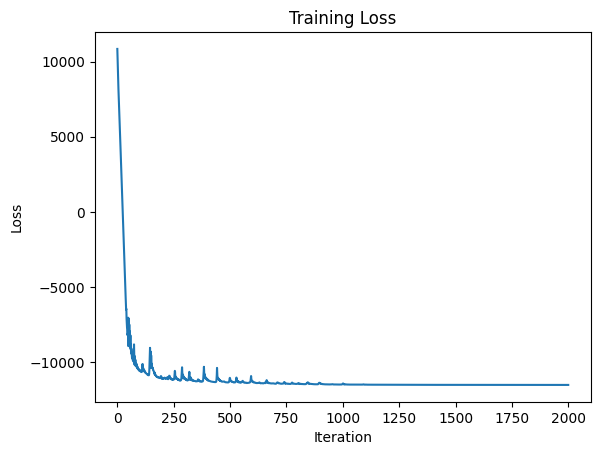

In [18]:
plt.plot(mf_gp.loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

Some residual test

In [19]:

# 🔹 5️⃣ Make Predictions on HF Test Set
num_test_points = X_test_HF.shape[0]
X_test_HF_aug = np.hstack([X_test_HF, np.ones((num_test_points, 1))])  # Append fidelity indicators
mean_pred, var_pred = mf_gp.predict_f(X_test_HF_aug)

# 🔹 6️⃣ Compute Residuals
residuals = mean_pred.numpy() - Y_test_HF  # Shape: (10, 49)

# ✅ Print summary
print(f"🔍 Final Residuals: {residuals.mean():.4f} ± {residuals.std():.4f}")
print(f"✅ Model trained and predictions completed!")

# ✅ Check Learned W Matrix
print("🔍 Final Learned W Matrix:")
print(mf_gp.kernel.W.numpy())

# ✅ Check Noise Variance
print(f"🔍 Learned noise variance: {mf_gp.likelihood.variance.numpy()}")

# ✅ Evaluate Test Performance
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test_HF, mean_pred.numpy())
print(f"🔍 HF Prediction MSE: {mse:.4f}")

🔍 Final Residuals: -0.0001 ± 0.0579
✅ Model trained and predictions completed!
🔍 Final Learned W Matrix:
[[ 0.42716931  0.02353248  0.2437398  -0.08468638 -0.0383619 ]
 [ 0.34997088  0.01957702  0.33628931 -0.11313729 -0.0389967 ]
 [ 0.29601186  0.02824997  0.39334932 -0.0873508  -0.09073   ]
 [ 0.27178332  0.05969435  0.41085594 -0.00590056 -0.19442678]
 [ 0.2773607   0.06459815  0.41273415  0.06191518 -0.28455014]
 [ 0.32926997 -0.00634939  0.43237207  0.15088445 -0.2742448 ]
 [ 0.36672981 -0.06399762  0.47228747  0.25920345 -0.19317228]
 [ 0.41544467 -0.07174252  0.48671451  0.36719088 -0.07179259]
 [ 0.5001832   0.11506251  0.37774152  0.49558703  0.0217248 ]
 [ 0.79603291  0.05780739  0.37820237  0.17162086  0.66108897]]
🔍 Learned noise variance: 0.00544692527282514
🔍 HF Prediction MSE: 0.0034


Learned W Matrix

Text(0.5, 0, 'Latent Dimension')

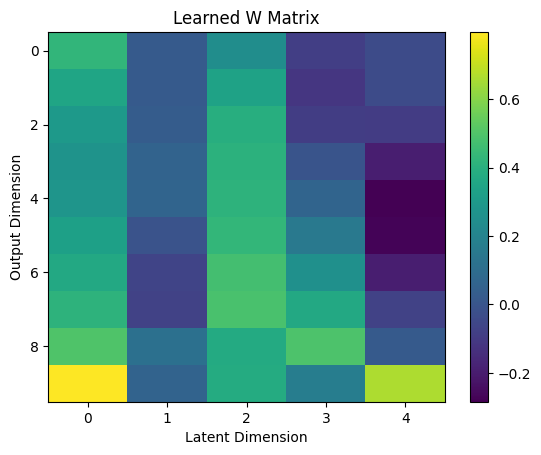

In [20]:
# plot the W matrix
plt.imshow(mf_gp.kernel.W.numpy(), aspect="auto")
plt.colorbar()
plt.title("Learned W Matrix")
plt.ylabel("Output Dimension")
plt.xlabel("Latent Dimension")

Prediction

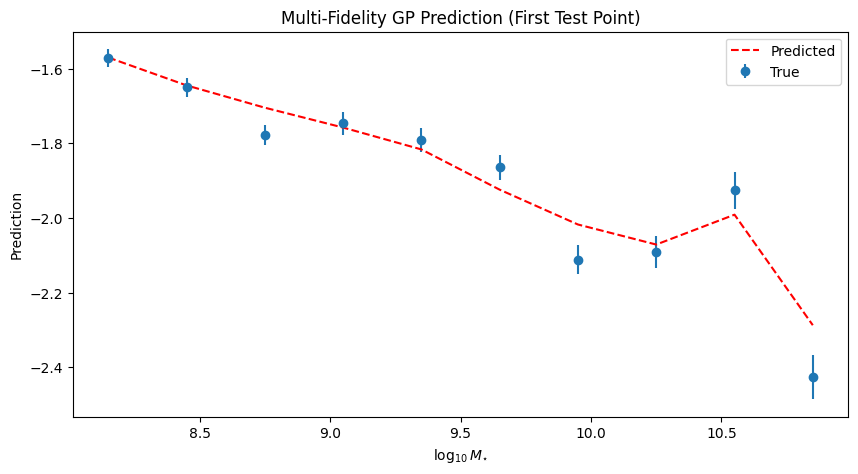

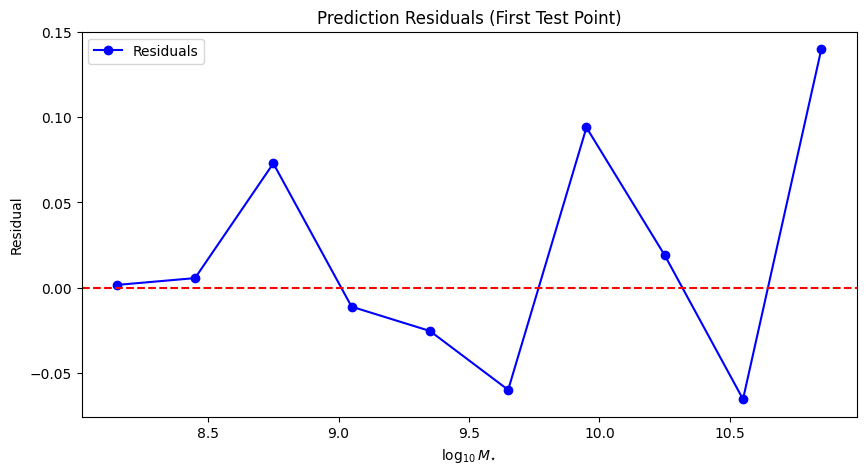

In [21]:
# 🔹 7️⃣ Plot Predictions vs Ground Truth
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.errorbar(log10_mass_bins, Y_test_HF[0], yerr=np.sqrt(var_pred.numpy()[0]), fmt='o', label="True")
plt.plot(log10_mass_bins, mean_pred.numpy()[0], 'r--', label="Predicted")
plt.xlabel(r"$\log_{10}M_{\star}$")
plt.ylabel("Prediction")
plt.legend()
plt.title("Multi-Fidelity GP Prediction (First Test Point)")
plt.show()

# 🔹 8️⃣ Residual Plot
plt.figure(figsize=(10, 5))
plt.plot(log10_mass_bins, residuals[0], 'bo-', label="Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(r"$\log_{10}M_{\star}$")
plt.ylabel("Residual")
plt.legend()
plt.title("Prediction Residuals (First Test Point)")
plt.show()

## Pred/Exact

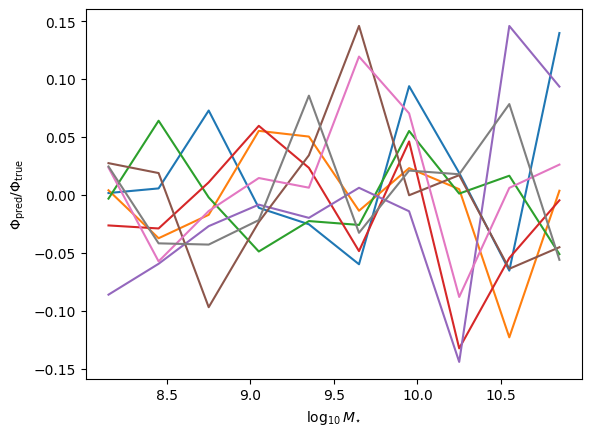

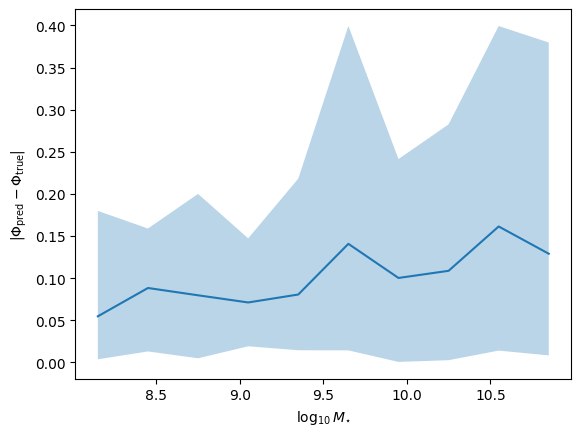

In [22]:
plt.plot(log10_mass_bins, (mean_pred - Y_test_HF).numpy().T);
plt.xlabel(r"$\log_{10}M_{\star}$")
plt.ylabel(r"$\Phi_{\mathrm{pred}}/\Phi_{\mathrm{true}}$")
plt.show()
# absolute error
relative_error = np.abs(10**mean_pred / 10**Y_test_HF - 1)
plt.plot(log10_mass_bins, relative_error.mean(axis=0));
plt.fill_between(log10_mass_bins, relative_error.min(axis=0), relative_error.max(axis=0), alpha=0.3)
plt.xlabel(r"$\log_{10}M_{\star}$")
plt.ylabel(r"$|\Phi_{\mathrm{pred}}-\Phi_{\mathrm{true}}|$")
plt.show()

## Diagnoistic plots

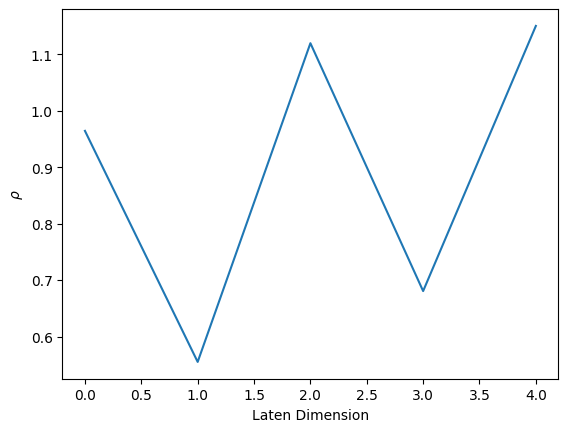

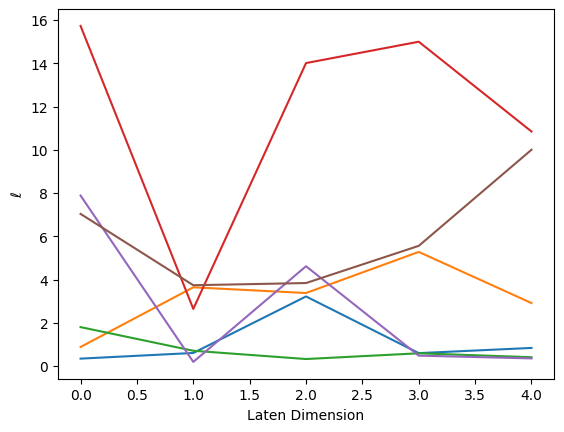

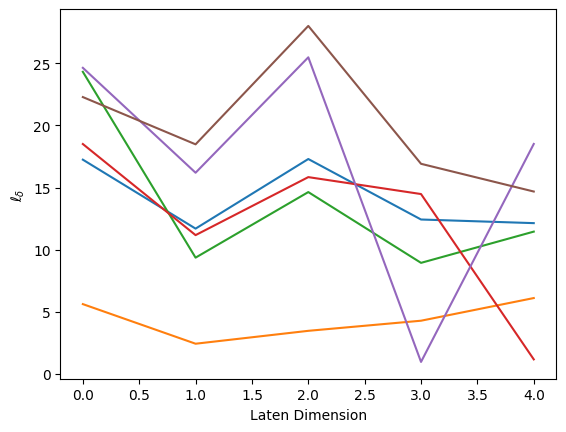

Text(0, 0.5, '$\\rho$')

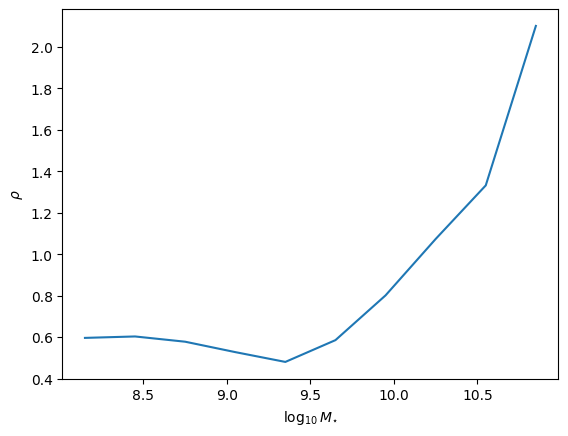

In [23]:
num_outputs = len(mf_gp.kernel.kernels)

rho_values = []
lengthscale_values = []
lengthscale_delta_values = []

for i in range(num_outputs):
    rho_values.append(mf_gp.kernel.kernels[i].rho.numpy()[0])
    lengthscale_values.append(mf_gp.kernel.kernels[i].kernel_L.lengthscales.numpy())
    lengthscale_delta_values.append(mf_gp.kernel.kernels[i].kernel_delta.lengthscales.numpy())


plt.plot(range(num_latents), rho_values)
plt.xlabel(r"Laten Dimension")
plt.ylabel(r"$\rho$")
plt.show()

plt.plot(range(num_latents), lengthscale_values)
plt.xlabel(r"Laten Dimension")
plt.ylabel(r"$\ell$")
plt.show()


plt.plot(range(num_latents), lengthscale_delta_values)
plt.xlabel(r"Laten Dimension")
plt.ylabel(r"$\ell_{\delta}$")
plt.show()

# Projected rho values
projected_rho = mf_gp.kernel.W.numpy() @ np.array(rho_values)
plt.plot(log10_mass_bins, projected_rho[:, 0])
plt.xlabel(r"$\log_{10}M_{\star}$")
plt.ylabel(r"$\rho$")